In [ ]:
#data loading

# df=pd.read_excel("Book1.xlsx")
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/talkingdata-adtracking-fraud-detection.zip"

Archive:  /content/drive/MyDrive/talkingdata-adtracking-fraud-detection.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_supplement.csv     
  inflating: train.csv               
  inflating: train_sample.csv        


In [ ]:
import matplotlib.pyplot as plt
import dask.dataframe as dd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score,roc_curve,recall_score,classification_report,mean_squared_error,confusion_matrix
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import lightgbm as lgb
from contextlib import contextmanager
import time
import random
from sklearn.model_selection import train_test_split as model_tts

In [ ]:
import pandas as pd
dfTrain = pd.read_csv("/content/train.csv", nrows=10000000)

In [ ]:
dfTest = pd.read_csv("/content/train.csv", skiprows=range(1, 10000000), nrows=10000000)

In [ ]:
dtyp = {'ip': np.int64, 'app': np.int16,'device': np.int16,'os': np.int16,'channel': np.int16,'is_attributed' : np.int16}

In [ ]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   ip               int64 
 1   app              int64 
 2   device           int64 
 3   os               int64 
 4   channel          int64 
 5   click_time       object
 6   attributed_time  object
 7   is_attributed    int64 
dtypes: int64(6), object(2)
memory usage: 610.4+ MB


In [ ]:
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   ip               int64 
 1   app              int64 
 2   device           int64 
 3   os               int64 
 4   channel          int64 
 5   click_time       object
 6   attributed_time  object
 7   is_attributed    int64 
dtypes: int64(6), object(2)
memory usage: 610.4+ MB


In [ ]:
def cleaning_transforming(dataframe):

    #this column is completely blank
    del dataframe['attributed_time']
    # Create new features out of time. Year and month are skipped as the data is only for 4 days
    dataframe['click_time'] =  dd.to_datetime(dataframe['click_time'])

    # # the given data is of 4 days. So useful data is day and hours
    dataframe['day'] = dataframe['click_time'].dt.day
    dataframe['hour'] = dataframe['click_time'].dt.hour
    del dataframe['click_time']

    dataframe.columns = ['ip', 'app', 'device', 'os','channel','is_attributed','day','hour']

    print("dataset columns",dataframe.columns)

    dataframe.astype(dtyp)
    print("\n\n=============================================================")
    print(dataframe.info())
    return dataframe




In [ ]:
dfTrain = cleaning_transforming(dfTrain)
dfTest = cleaning_transforming(dfTest)

dataset columns Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day', 'hour'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
 #   Column         Dtype
---  ------         -----
 0   ip             int64
 1   app            int64
 2   device         int64
 3   os             int64
 4   channel        int64
 5   is_attributed  int64
 6   day            int64
 7   hour           int64
dtypes: int64(8)
memory usage: 610.4 MB
None
dataset columns Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'day', 'hour'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
 #   Column         Dtype
---  ------         -----
 0   ip             int64
 1   app            int64
 2   device         int64
 3   os             int64
 4   channel        int64
 5   is_attributed  int64
 6   day            int64
 7   ho

In [ ]:
def check_true_positive_ratio(dfTest):
  dfTest = cleaning_transforming(dfTest)

In [ ]:
print("original dataframe")
dfTrain.head()

original dataframe


,ip,app,device,os,channel,is_attributed,day,hour
0,83230,3,1,13,379,0,6,14
1,17357,3,1,19,379,0,6,14
2,35810,3,1,13,379,0,6,14
3,45745,14,1,13,478,0,6,14
4,161007,3,1,13,379,0,6,14


In [ ]:
dfTest.head()

,ip,app,device,os,channel,is_attributed,day,hour
0,146470,15,1,10,278,0,7,0
1,117021,15,1,22,245,0,7,0
2,5348,3,1,13,211,0,7,0
3,27815,2,1,19,435,0,7,0
4,80306,1,1,22,118,0,7,0


In [ ]:
def check_true_positive_ratio(data):
    nrows = len(data)
    print("Number of rows in the dataframe: ", nrows)
    npositive = data.is_attributed.sum() #since is_attributed has either 0 or 1. 1 is for positive cases
    print("Number of positive cases are " + str(npositive))
    nnegative = nrows - npositive
    positive_ratio = np.longdouble(npositive/nrows)
    print("Positive data ratio is ", positive_ratio*100, "%")

In [ ]:
def positive_set(dataframe):
    #nRows = len(dataframe)
    #nPos = dataframe.is_attributed.sum()
    #nNeg = nRows - nPos
    #r = np.longdouble(nPos/nRows)
    posEx = dataframe [ (dataframe['is_attributed'] == 1) ]
    #print("Number of positive data is " + str(len(posEx)) + " rows")
    return posEx

In [ ]:
def downsampling(dataframe, posDataframe):
    nRows = len(dataframe)
    nPos = len(posDataframe)
    nNeg = nRows - nPos
    r = np.longdouble(nPos/nRows)
    #randomly shuffle the dataframe and pick negative rows with shuffling and replacement
    random_int = random.randint(1,50)
    random_state = np.random.RandomState(random_int)
    sampledNegEx =  dataframe [ (dataframe['is_attributed'] == 0) ].sample(frac=r,random_state=random_state)
    newTrainsubs = [posDataframe, sampledNegEx]
    dfTrainBal = pd.concat(newTrainsubs)
    newRows = len(dfTrainBal)
    newPos = dfTrainBal.is_attributed.sum()
    newNeg = nRows - nPos
    rr = np.longdouble(newPos/newRows)
    return dfTrainBal

In [ ]:
def create_chunks(dataframe):
    print("Creating 10 chunks")
    #get only positive data
    pos_set = positive_set(dataframe)
    #downsample the data to get balanced chunk
    balanced_chunks = []
    for i in range(10):
        balanced_chunks.append(downsampling(dataframe, pos_set))

    return balanced_chunks

In [ ]:
dfTrainBal = create_chunks(dfTrain)

Creating 10 chunks


In [ ]:
print("Checking positive ratio in each chunk now")
for chunk in dfTrainBal:
    check_true_positive_ratio(chunk)
    print("===============================")

Checking positive ratio in each chunk now
Number of rows in the dataframe:  37399
Number of positive cases are 18717
Positive data ratio is  50.04679269499184846 %
Number of rows in the dataframe:  37399
Number of positive cases are 18717
Positive data ratio is  50.04679269499184846 %
Number of rows in the dataframe:  37399
Number of positive cases are 18717
Positive data ratio is  50.04679269499184846 %
Number of rows in the dataframe:  37399
Number of positive cases are 18717
Positive data ratio is  50.04679269499184846 %
Number of rows in the dataframe:  37399
Number of positive cases are 18717
Positive data ratio is  50.04679269499184846 %
Number of rows in the dataframe:  37399
Number of positive cases are 18717
Positive data ratio is  50.04679269499184846 %
Number of rows in the dataframe:  37399
Number of positive cases are 18717
Positive data ratio is  50.04679269499184846 %
Number of rows in the dataframe:  37399
Number of positive cases are 18717
Positive data ratio is  50.04

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing 'is_attributed' column
value_counts = dfTrain['is_attributed'].value_counts(normalize=True) * 100

# Extracting values and index labels
values = value_counts.values
labels = value_counts.index.astype(str)

# Creating a bar plot
plt.bar(labels, values, color=['blue', 'orange'])

# Adding percentages above bars
for i in range(len(labels)):
    plt.text(i, values[i] + 0.5, f'{values[i]:.2f}%', ha='center')

# Adding title and labels
plt.title("Plot of App Downloaded vs Not Downloaded")
plt.xlabel("Attribution")
plt.ylabel("Percentage")

# Display the plot
plt.show()

In [ ]:
dfTrainBal[0] [ (dfTrainBal[0]['is_attributed'] == 0) ].head()



dfTrainBal[1] [ (dfTrainBal[1]['is_attributed'] == 0) ].head()

dfTrainBal[2] [ (dfTrainBal[2]['is_attributed'] == 0) ].head()

dfTrainBal[3] [ (dfTrainBal[3]['is_attributed'] == 0) ].head()

,ip,app,device,os,channel,is_attributed,day,hour
3710250,15773,3,1,16,115,0,6,18
9509254,103672,2,1,19,469,0,7,0
7890067,93012,12,1,19,178,0,6,23
1842856,7246,9,1,13,258,0,6,16
3328071,61489,12,1,13,259,0,6,17


In [ ]:
def draw_roc(clf, chunk):
    #building data for crossvalidation
    random_int = random.randint(1,10)
    random_state = np.random.RandomState(random_int)
    split_size = 0.3
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True )
    #Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed',axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed',axis=1)
    tprs = []
    aucs = []
    result_dict = {}

    mean_fpr = np.linspace(0, 1, 100)
    model = clf.fit(xTrain, yTrain)
    probas_ = model.predict_proba(xCV)
    fpr, tpr, thresholds = roc_curve(yCV, probas_[:, 1])

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (0, roc_auc))
    result_dict["model"] = model
    result_dict["fpr"] = fpr
    result_dict["tpr"] = tpr
    result_dict["lw"] = 1
    result_dict["alpha"] = 0.3
    result_dict["roc_fold"] = 0
    result_dict["roc_auc"] = roc_auc
    #print(str(clf), str(roc_auc))
    return result_dict


In [ ]:
#building model for logistic regression
dTrain = pd.DataFrame()

dCV = pd.DataFrame()

best_model_lr = {}

model_list_lr = []

best_auc_lr = np.float64(0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.7855635605355281


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.7874600248584154


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.7668133660113904


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.783743478667579


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.7844271636690483


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.7851341550305388


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.7815469943926375


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.7677766049765602


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.7859066396055723
0.7718013618583008
best auc is  0.7874600248584154
ROC curve for validation set for logistic regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


LogisticRegression()

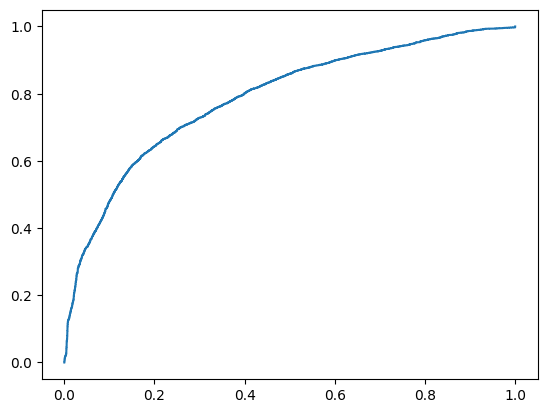

In [ ]:
#building model
for chunk in dfTrainBal:
    clfLR = LogisticRegression()
    results_lr = draw_roc(clfLR, chunk)
    print(results_lr["roc_auc"])
    model_list_lr.append(results_lr)


for model in model_list_lr:
    if(np.greater(model["roc_auc"], best_auc_lr)):
        best_auc_lr = model["roc_auc"]
        best_model_lr = model

print("best auc is " , best_model_lr["roc_auc"])

print("ROC curve for validation set for logistic regression")
plt.plot(best_model_lr["fpr"],
          best_model_lr["tpr"], best_model_lr["lw"], best_model_lr["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, best_model_lr["roc_auc"]))

best_model_lr["model"]

In [ ]:
def get_roc_test(model, test_data):
    yTest = test_data['is_attributed']
    xTest = test_data.drop('is_attributed',axis=1)
    tprs = []
    aucs = []
    result_dict = {}
    mean_fpr = np.linspace(0, 1, 100)
    probas_ = model.predict_proba(xTest)
    fpr, tpr, thresholds = roc_curve(yTest, probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (0, roc_auc))
    # result_dict["model"] = clf   should be there
    result_dict["fpr"] = fpr
    result_dict["tpr"] = tpr
    result_dict["lw"] = 1
    result_dict["alpha"] = 0.3
    result_dict["roc_fold"] = 0
    result_dict["roc_auc"] = roc_auc
    #print(str(clf), str(roc_auc))
    return result_dict

In [ ]:
def display_accuracy(model, test_data):
    yTest = test_data['is_attributed']
    xTest = test_data.drop('is_attributed',axis=1)
    y_pred = model.predict(xTest)
    print("Model's on test set: {:.2f}".format(model.score(xTest, yTest)))

In [ ]:
def display_confusion_matrix(model, test_data):
    yTest = test_data['is_attributed']
    xTest = test_data.drop('is_attributed',axis=1)
    y_pred = model.predict(xTest)
    confusion_matrx = confusion_matrix(yTest, y_pred)
    print(confusion_matrx)
    return confusion_matrx

In [ ]:
def display_classification_report(model, test_data):
    yTest = test_data['is_attributed']
    xTest = test_data.drop('is_attributed',axis=1)
    y_pred = model.predict(xTest)
    print(classification_report(yTest, y_pred))


In [ ]:
dfTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
 #   Column         Dtype
---  ------         -----
 0   ip             int64
 1   app            int64
 2   device         int64
 3   os             int64
 4   channel        int64
 5   is_attributed  int64
 6   day            int64
 7   hour           int64
dtypes: int64(8)
memory usage: 610.4 MB


best model's auc on test set for logistic regression is  0.8529516538468375
ROC curve for test set for logistic regression


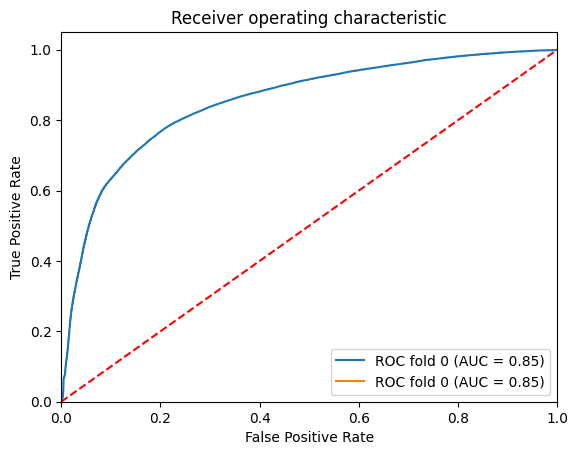

In [ ]:
#Testing best model for logistic regression
test_lr = get_roc_test(best_model_lr["model"], dfTest)
print("best model's auc on test set for logistic regression is " , test_lr["roc_auc"])
print("ROC curve for test set for logistic regression")
plt.plot(test_lr["fpr"],
          test_lr["tpr"], test_lr["lw"], test_lr["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, test_lr["roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
#displaying accuracy of logistic model
print("Logistic Model Accuracy")
display_accuracy(best_model_lr["model"], dfTest)

Logistic Model Accuracy
Model's on test set: 0.37


In [ ]:
#printing model's confusion matrix for logistic regression
print("Logistic Model Confusion Matrix")
confsn_matrx = display_confusion_matrix(best_model_lr["model"], dfTest)
correct_predictions = confsn_matrx[0][0] + confsn_matrx[1][1]
incorrect_predictions = confsn_matrx[0][1] + confsn_matrx[1][0]
print("Number of correct predictions: ", correct_predictions)
print("Number of incorrect predictions: ", incorrect_predictions)

display_classification_report(best_model_lr["model"], dfTest)

Logistic Model Confusion Matrix
[[3623671 6345582]
 [   1546   29201]]
Number of correct predictions:  3652872
Number of incorrect predictions:  6347128
              precision    recall  f1-score   support

           0       1.00      0.36      0.53   9969253
           1       0.00      0.95      0.01     30747

    accuracy                           0.37  10000000
   macro avg       0.50      0.66      0.27  10000000
weighted avg       1.00      0.37      0.53  10000000



In [ ]:
#building model with random forest
dTrain = pd.DataFrame()

dCV = pd.DataFrame()

split_size = 0.2
best_model_rf = {}
model_list_rf = []
best_auc_rf = np.float64(0)


In [ ]:
#building model
for chunk in dfTrainBal:
    random_int = random.randint(1,10)
    random_state = np.random.RandomState(random_int)
    #building data for crossvalidation
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True )
    #Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed',axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed',axis=1)
    clfRF = RandomForestClassifier(n_estimators=100,random_state=random_state)
    results_rf = draw_roc(clfRF, chunk)
    model_list_rf.append(results_rf)
    print(results_rf["roc_auc"])

<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9452278607397131


<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9418517906103032


<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9440681675602414


<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9455608231494973


<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9453280111210406


<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.943797147297283


<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9449680648521627


<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9450774101273182


<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9449064912810735
0.946763117969105


<ipython-input-21-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


best auc is  0.946763117969105
ROC curve for validation set for random forest


RandomForestClassifier(random_state=RandomState(MT19937) at 0x7E1855B38D40)

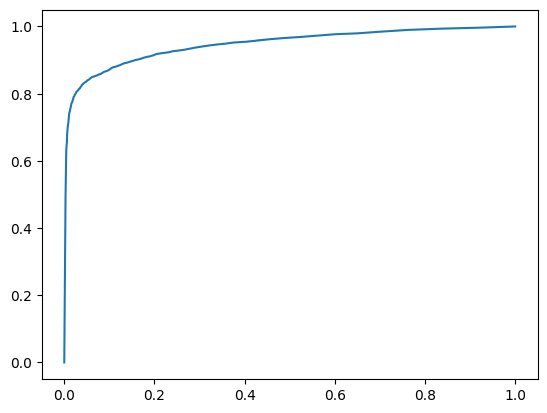

In [ ]:
for model in model_list_rf:
    if(np.greater(model["roc_auc"], best_auc_rf)):
        best_auc_rf = model["roc_auc"]
        best_model_rf = model

print("best auc is " , best_model_rf["roc_auc"])
print("ROC curve for validation set for random forest")
plt.plot(best_model_rf["fpr"],
          best_model_rf["tpr"], best_model_rf["lw"], best_model_rf["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, best_model_rf["roc_auc"]))

best_model_rf["model"]

best model's auc on test set for random forest is  0.9539546109923449
ROC curve for test set for random forest


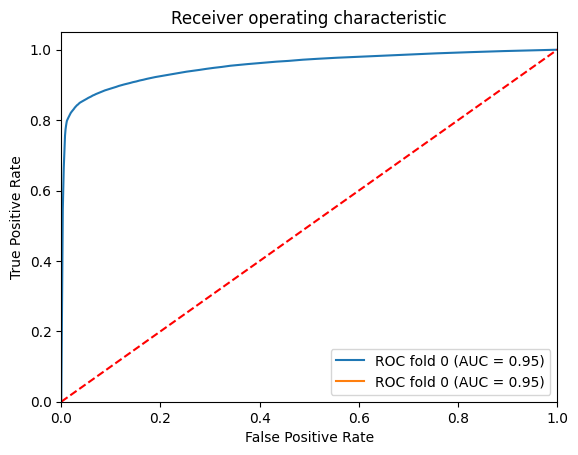

In [ ]:
#Testing best model for Random Forest
test_rf = get_roc_test(best_model_rf["model"], dfTest)
print("best model's auc on test set for random forest is " , test_rf["roc_auc"])
# #print(dTrain.head())
print("ROC curve for test set for random forest")
plt.plot(test_rf["fpr"],
          test_rf["tpr"], test_rf["lw"], test_rf["alpha"],
          label='ROC fold %d (AUC = %0.2f)' % (0, test_rf["roc_auc"]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
#displaying accuracy of random forest
print("Random Forest Accuracy")
display_accuracy(best_model_rf["model"], dfTest)

Random Forest Accuracy
Model's on test set: 0.93


In [ ]:
#printing model's confusion matrix for random forest
print("Random Forest Confusion Matrix")
confsn_matrx = display_confusion_matrix(best_model_rf["model"], dfTest)
correct_predictions = confsn_matrx[0][0] + confsn_matrx[1][1]
incorrect_predictions = confsn_matrx[0][1] + confsn_matrx[1][0]
print("Number of correct predictions: ", correct_predictions)
print("Number of incorrect predictions: ", incorrect_predictions)

Random Forest Confusion Matrix
[[9272637  696616]
 [   3873   26874]]
Number of correct predictions:  9299511
Number of incorrect predictions:  700489


In [ ]:
display_classification_report(best_model_rf["model"], dfTest)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96   9969253
           1       0.04      0.87      0.07     30747

    accuracy                           0.93  10000000
   macro avg       0.52      0.90      0.52  10000000
weighted avg       1.00      0.93      0.96  10000000



In [ ]:
#building model for XGBoost
dTrain = pd.DataFrame()

dCV = pd.DataFrame()

best_model_xgb = {}

model_list_xgb = []

best_auc_xgb = np.float64(0)

In [ ]:
from xgboost import XGBClassifier
# Building XGBoost model
for chunk in dfTrainBal:
    random_int = random.randint(1, 10)
    random_state = np.random.RandomState(random_int)

    # Building data for cross-validation
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True)

    # Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed', axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed', axis=1)

    # XGBoost classifier
    clfXGB = XGBClassifier(n_estimators=100, random_state=random_state)
    results_xgb = draw_roc(clfXGB, chunk)
    model_list_xgb.append(results_xgb)
    print(results_xgb["roc_auc"])



<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9253140498437525
0.9412252427184465
0.9296194174757282


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.931120107647315
0.9303844660194174
0.922844331404393


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9254644991335567
0.9253603267791135
0.9221067961165049
0.9289495145631068


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


Best AUC is 0.9412252427184465
ROC curve for validation set for XGBoost


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=2128391943, ...)

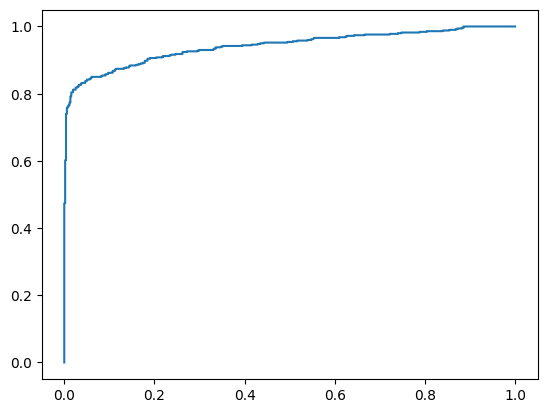

In [ ]:
# Selecting the best model based on AUC
for model in model_list_xgb:
    if np.greater(model["roc_auc"], best_auc_xgb):
        best_auc_xgb = model["roc_auc"]
        best_model_xgb = model

print("Best AUC is", best_model_xgb["roc_auc"])
print("ROC curve for validation set for XGBoost")
plt.plot(best_model_xgb["fpr"],
         best_model_xgb["tpr"], best_model_xgb["lw"], best_model_xgb["alpha"],
         label='ROC fold %d (AUC = %0.2f)' % (0, best_model_xgb["roc_auc"]))

best_model_xgb["model"]

In [ ]:
# Testing the best model for XGBoost
test_xgb = get_roc_test(best_model_xgb["model"], dfTest)
print("Best model's AUC on test set for XGBoost is", test_xgb["roc_auc"])

Best model's AUC on test set for XGBoost is 0.9367450926665831


ROC curve for test set for XGBoost


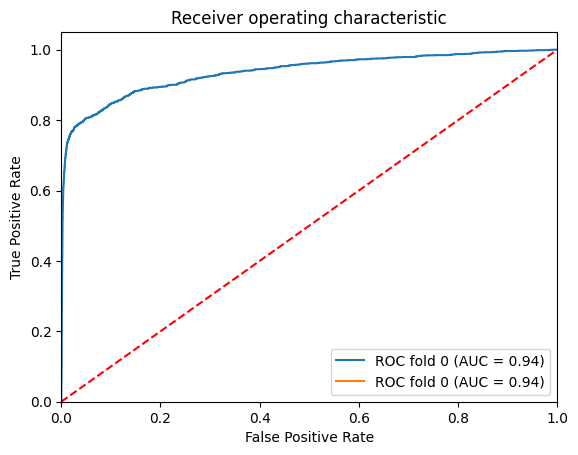

In [ ]:
# ROC curve for test set for XGBoost
print("ROC curve for test set for XGBoost")
plt.plot(test_xgb["fpr"],
         test_xgb["tpr"], test_xgb["lw"], test_xgb["alpha"],
         label='ROC fold %d (AUC = %0.2f)' % (0, test_xgb["roc_auc"]))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGBoost_ROC')
plt.show()

In [ ]:
# Displaying accuracy of XGBoost
print("XGBoost Accuracy")
display_accuracy(best_model_xgb["model"], dfTest)

XGBoost Accuracy
Model's on test set: 0.89


In [ ]:
# Printing model's confusion matrix for XGBoost
print("XGBoost Confusion Matrix")
confusion_matrix_xgb = display_confusion_matrix(best_model_xgb["model"], dfTest)
correct_predictions_xgb = confusion_matrix_xgb[0][0] + confusion_matrix_xgb[1][1]
incorrect_predictions_xgb = confusion_matrix_xgb[0][1] + confusion_matrix_xgb[1][0]
print("Number of correct predictions: ", correct_predictions_xgb)
print("Number of incorrect predictions: ", incorrect_predictions_xgb)

XGBoost Confusion Matrix
[[887063 111242]
 [   250   1445]]
Number of correct predictions:  888508
Number of incorrect predictions:  111492


In [ ]:
display_classification_report(best_model_xgb["model"], dfTest)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    998305
           1       0.01      0.85      0.03      1695

    accuracy                           0.89   1000000
   macro avg       0.51      0.87      0.48   1000000
weighted avg       1.00      0.89      0.94   1000000



In [ ]:
from sklearn.svm import SVC
# Assuming dfTrainBal is your training dataset and dfTest is your testing dataset

dTrain = pd.DataFrame()
dCV = pd.DataFrame()
split_size = 0.2
best_model_svm = {}
model_list_svm = []
best_auc_svm = np.float64(0)


In [ ]:
# Building SVM model
for chunk in dfTrainBal:
    random_int = random.randint(1, 10)
    random_state = np.random.RandomState(random_int)

    # Building data for cross-validation
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True)

    # Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed', axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed', axis=1)

    # SVM classifier
    clfSVM = SVC(probability=True, random_state=random_state)
    results_svm = draw_roc(clfSVM, chunk)
    model_list_svm.append(results_svm)
    print(results_svm["roc_auc"])


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.6892660194174758


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.6949488004226491


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.6751232810652728


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.6821741562558269


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.6617568135150271


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.6639938744733447


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.6769833504177927


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.6898368932038834


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.6659844660194174
0.684106765491951


<ipython-input-22-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


Best AUC is 0.6949488004226491
ROC curve for validation set for SVM


SVC(probability=True, random_state=RandomState(MT19937) at 0x7E4302909D40)

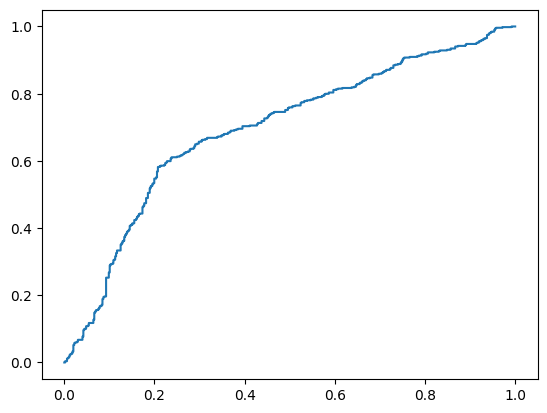

In [ ]:
# Selecting the best model based on AUC
for model in model_list_svm:
    if np.greater(model["roc_auc"], best_auc_svm):
        best_auc_svm = model["roc_auc"]
        best_model_svm = model

print("Best AUC is", best_model_svm["roc_auc"])
print("ROC curve for validation set for SVM")
plt.plot(best_model_svm["fpr"],
         best_model_svm["tpr"], best_model_svm["lw"], best_model_svm["alpha"],
         label='ROC fold %d (AUC = %0.2f)' % (0, best_model_svm["roc_auc"]))

best_model_svm["model"]

In [ ]:
# Testing the best model for SVM
test_svm = get_roc_test(best_model_svm["model"], dfTest)
print("Best model's AUC on test set for SVM is", test_svm["roc_auc"])

Best model's AUC on test set for SVM is 0.6644207471487178


ROC curve for test set for SVM


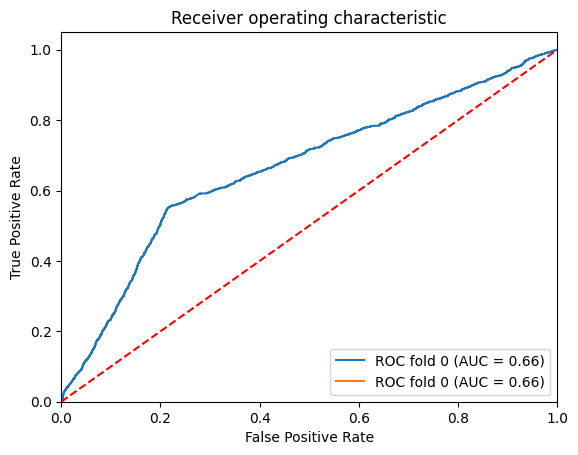

In [ ]:
# ROC curve for test set for SVM
print("ROC curve for test set for SVM")
plt.plot(test_svm["fpr"],
         test_svm["tpr"], test_svm["lw"], test_svm["alpha"],
         label='ROC fold %d (AUC = %0.2f)' % (0, test_svm["roc_auc"]))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('SVM_ROC')
plt.show()

In [ ]:
# Displaying accuracy of SVM
print("SVM Accuracy")
display_accuracy(best_model_svm["model"], dfTest)

SVM Accuracy
Model's on test set: 0.76


In [ ]:
# Printing model's confusion matrix for SVM
print("SVM Confusion Matrix")
confusion_matrix_svm = display_confusion_matrix(best_model_svm["model"], dfTest)
correct_predictions_svm = confusion_matrix_svm[0][0] + confusion_matrix_svm[1][1]
incorrect_predictions_svm = confusion_matrix_svm[0][1] + confusion_matrix_svm[1][0]
print("Number of correct predictions: ", correct_predictions_svm)
print("Number of incorrect predictions: ", incorrect_predictions_svm)

SVM Confusion Matrix
[[757549 240756]
 [   738    957]]
Number of correct predictions:  758506
Number of incorrect predictions:  241494


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
dTrain = pd.DataFrame()
dCV = pd.DataFrame()
split_size = 0.3
best_model_adaboost = {}
model_list_adaboost = []
best_auc_adaboost = np.float64(0)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize lists to store metrics
f1_scores = []
recall_scores = []
precision_scores = []
training_accuracies = []
testing_accuracies = []

for chunk in dfTrainBal:
    random_int = random.randint(1, 10)
    random_state = np.random.RandomState(random_int)

    # Building data for cross-validation
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True)

    # Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed', axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed', axis=1)

    # AdaBoost classifier
    clfAdaBoost = AdaBoostClassifier(n_estimators=50, random_state=random_state)
    clfAdaBoost.fit(xTrain, yTrain)

    # Compute predictions
    y_train_pred = clfAdaBoost.predict(xTrain)
    y_test_pred = clfAdaBoost.predict(xCV)

    # Compute metrics
    f1 = f1_score(yCV, y_test_pred)
    recall = recall_score(yCV, y_test_pred)
    precision = precision_score(yCV, y_test_pred)
    train_accuracy = accuracy_score(yTrain, y_train_pred)
    test_accuracy = accuracy_score(yCV, y_test_pred)

    # Append metrics to lists
    f1_scores.append(f1)
    recall_scores.append(recall)
    precision_scores.append(precision)
    training_accuracies.append(train_accuracy)
    testing_accuracies.append(test_accuracy)

    print("F1 Score:", f1)
    print("Recall:", recall)
    print("Precision:", precision)
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)

# Average metrics over all chunks
avg_f1 = sum(f1_scores) / len(f1_scores)
avg_recall = sum(recall_scores) / len(recall_scores)
avg_precision = sum(precision_scores) / len(precision_scores)
avg_train_accuracy = sum(training_accuracies) / len(training_accuracies)
avg_test_accuracy = sum(testing_accuracies) / len(testing_accuracies)

print("Average F1 Score:", avg_f1)
print("Average Recall:", avg_recall)
print("Average Precision:", avg_precision)
print("Average Training Accuracy:", avg_train_accuracy)
print("Average Testing Accuracy:", avg_test_accuracy)



F1 Score: 0.848156392141682
Recall: 0.7857270934194011
Precision: 0.9213624894869639
Training Accuracy: 0.8623706023912296
Testing Accuracy: 0.8601604278074866
F1 Score: 0.8517777142312458
Recall: 0.788146057505733
Precision: 0.9265864786395687
Training Accuracy: 0.8622942052790404
Testing Accuracy: 0.8614081996434938
F1 Score: 0.8496456617506225
Recall: 0.7877819215059492
Precision: 0.9220536271045521
Training Accuracy: 0.8616830283815272
Testing Accuracy: 0.8600713012477719
F1 Score: 0.8517344095320457
Recall: 0.789736279401283
Precision: 0.92429614181439
Training Accuracy: 0.8639367431911074
Testing Accuracy: 0.8624777183600713
F1 Score: 0.8496583143507973
Recall: 0.7870582029189379
Precision: 0.9230769230769231
Training Accuracy: 0.8603078803621224
Testing Accuracy: 0.8588235294117647
F1 Score: 0.855303612605688
Recall: 0.7904457467590126
Precision: 0.9317563324262089
Training Accuracy: 0.8631345735131212
Testing Accuracy: 0.8657754010695187
F1 Score: 0.8503199923583915
Recall: 0.7

In [ ]:
confusion_matrix_xgb = display_confusion_matrix(best_model_xgb["model"], dfTest)
correct_predictions_xgb = confusion_matrix_xgb[0][0] + confusion_matrix_xgb[1][1]
incorrect_predictions_xgb = confusion_matrix_xgb[0][1] + confusion_matrix_xgb[1][0]
print("Number of correct predictions: ", correct_predictions_xgb)
print("Number of incorrect predictions: ", incorrect_predictions_xgb)
display_classification_report(best_model_xgb["model"], dfTest)

Best AUC is 0.9396111558164972
ROC curve for validation set for AdaBoost


AdaBoostClassifier(random_state=RandomState(MT19937) at 0x7B728EF93340)

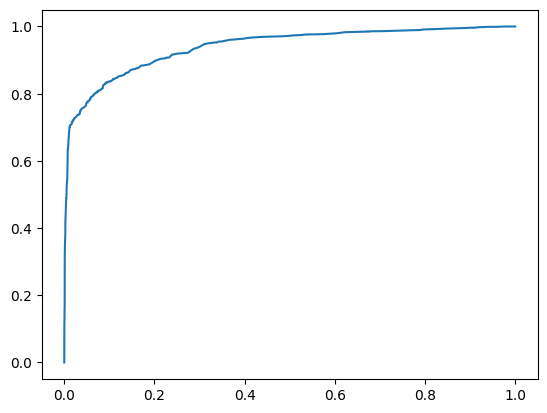

In [ ]:
# Selecting the best model based on AUC
for model in model_list_adaboost:
    if np.greater(model["roc_auc"], best_auc_adaboost):
        best_auc_adaboost = model["roc_auc"]
        best_model_adaboost = model

print("Best AUC is", best_model_adaboost["roc_auc"])
print("ROC curve for validation set for AdaBoost")
plt.plot(best_model_adaboost["fpr"],
         best_model_adaboost["tpr"], best_model_adaboost["lw"], best_model_adaboost["alpha"],
         label='ROC fold %d (AUC = %0.2f)' % (0, best_model_adaboost["roc_auc"]))

best_model_adaboost["model"]

In [ ]:
# Testing the best model for AdaBoost
test_adaboost = get_roc_test(best_model_adaboost["model"], dfTest)
print("Best model's AUC on test set for AdaBoost is", test_adaboost["roc_auc"])

Best model's AUC on test set for AdaBoost is 0.9485468530503136


ROC curve for test set for AdaBoost


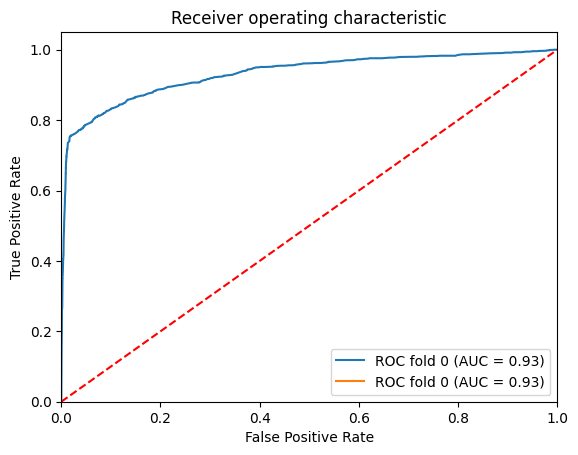

In [ ]:
# ROC curve for test set for AdaBoost
print("ROC curve for test set for AdaBoost")
plt.plot(test_adaboost["fpr"],
         test_adaboost["tpr"], test_adaboost["lw"], test_adaboost["alpha"],
         label='ROC fold %d (AUC = %0.2f)' % (0, test_adaboost["roc_auc"]))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('AdaBoost_ROC')
plt.show()

In [ ]:
# Displaying accuracy of AdaBoost
print("AdaBoost Accuracy")
display_accuracy(best_model_adaboost["model"], dfTest)


AdaBoost Accuracy
Model's on test set: 0.93


In [ ]:
# Printing model's confusion matrix for AdaBoost
print("AdaBoost Confusion Matrix")
confusion_matrix_adaboost = display_confusion_matrix(best_model_adaboost["model"], dfTest)
correct_predictions_adaboost = confusion_matrix_adaboost[0][0] + confusion_matrix_adaboost[1][1]
incorrect_predictions_adaboost = confusion_matrix_adaboost[0][1] + confusion_matrix_adaboost[1][0]
print("Number of correct predictions: ", correct_predictions_adaboost)
print("Number of incorrect predictions: ", incorrect_predictions_adaboost)

AdaBoost Confusion Matrix
[[923690  74615]
 [   318   1377]]
Number of correct predictions:  925067
Number of incorrect predictions:  74933


In [ ]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 16.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier  # Import CatBoost classifier

dTrain = pd.DataFrame()
dCV = pd.DataFrame()
split_size = 0.3
best_model_catboost = {}  # Dictionary to store the best CatBoost model
model_list_catboost = []  # List to store models and their metrics
best_auc_catboost = np.float64(0)  # Initialize best AUC




In [ ]:
# Building CatBoost model
for chunk in dfTrainBal:
    random_int = random.randint(1, 10)
    random_state = np.random.RandomState(random_int)

    # Building data for cross-validation
    dTrain, dCV = model_tts(chunk, test_size=split_size, random_state=random_state, shuffle=True)

    # Get X and y
    yTrain = dTrain['is_attributed']
    xTrain = dTrain.drop('is_attributed', axis=1)
    yCV = dCV['is_attributed']
    xCV = dCV.drop('is_attributed', axis=1)

    # CatBoost classifier
    clfCatBoost = CatBoostClassifier(iterations=50, random_seed=random_int, logging_level='Silent')
    clfCatBoost.fit(xTrain, yTrain)

    # Evaluate CatBoost model
    results_catboost = draw_roc(clfCatBoost, chunk)
    model_list_catboost.append(results_catboost)
    print(results_catboost["roc_auc"])



<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9541758792572734


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9557301969481887


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9542524301768506


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9546737205838546


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9567555678462316


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9552543342269885


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9543564576624322


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9528863900300072


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


0.9546176291500872
0.9555552151811937


<ipython-input-20-49d54e7f5a0b>:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


In [ ]:
# Selecting the best model based on AUC
for model in model_list_catboost:
    if np.greater(model["roc_auc"], best_auc_catboost):
        best_auc_catboost = model["roc_auc"]
        best_model_catboost = model


Best AUC is 0.9567555678462316
ROC curve for validation set for CatBoost


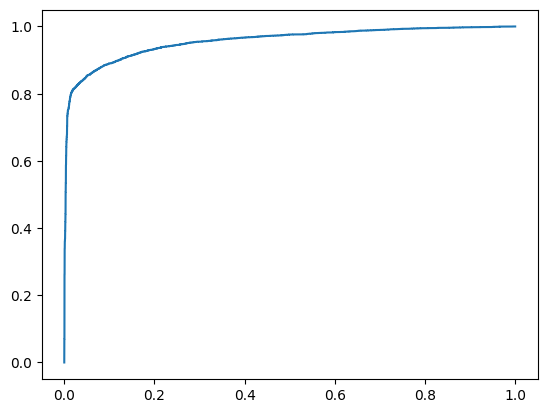

In [ ]:

print("Best AUC is", best_model_catboost["roc_auc"])
print("ROC curve for validation set for CatBoost")
plt.plot(best_model_catboost["fpr"],
         best_model_catboost["tpr"], best_model_catboost["lw"], best_model_catboost["alpha"],
         label='ROC fold %d (AUC = %0.2f)' % (0, best_model_catboost["roc_auc"]))


In [ ]:
# Displaying accuracy of CatBoost
print("CatBoost Accuracy")
display_accuracy(best_model_catboost["model"], dfTest)

CatBoost Accuracy
Model's on test set: 0.94


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    # Add more hyperparameters to tune
}

# Perform grid search
grid_search = GridSearchCV(estimator=CatBoostClassifier(random_seed=42, logging_level='Silent'),
                           param_grid=param_grid, cv=3, scoring='roc_auc')
grid_search.fit(xTrain, yTrain)

# Get the best model
best_model_catboost = grid_search.best_estimator_




In [ ]:
xTrain = dfTrain.drop('is_attributed', axis=1)
yTrain = dfTrain['is_attributed']
xTest = dfTest.drop('is_attributed', axis=1)
yTest = dfTest['is_attributed']

In [ ]:
# Print the best parameters and ROC AUC score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC:", grid_search.best_score_)



Best Parameters: {'iterations': 200, 'learning_rate': 0.1}
Best ROC AUC: 0.9551737945157709


In [ ]:
# Make predictions on the test set
y_pred = best_model_catboost.predict(xTest)

# Evaluate the model performance on the test set
test_auc = roc_auc_score(yTest, y_pred)
print("Test ROC AUC:", test_auc)

Test ROC AUC: 0.9120444595775684


In [ ]:
# Make predictions on the test set
y_pred = best_model_catboost.predict(xTest)

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

# Define the best hyperparameters obtained from hyperparameter tuning
best_params = {
    'iterations': 200,
    'learning_rate': 0.1,
    'depth': 6,  # Depth of the trees
    'l2_leaf_reg': 3,  # L2 regularization coefficient
    'bagging_temperature': 0.5,  # Bagging temperature
    # Add other best hyperparameters here
}

# Create a CatBoostClassifier instance with the best hyperparameters
best_clf = CatBoostClassifier(**best_params, logging_level='Silent', random_seed=42)

# Train the best classifier on the entire training data
best_clf.fit(xTrain, yTrain)

# Make predictions on the testing set
yTest_pred = best_clf.predict(xTest)

# Calculate testing accuracy
test_accuracy = accuracy_score(yTest, yTest_pred)
print("Testing Accuracy (after hyperparameter tuning):", test_accuracy)


Testing Accuracy (after hyperparameter tuning): 0.9980002


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision
precision = precision_score(yTest, yTest_pred)

# Calculate recall
recall = recall_score(yTest, yTest_pred)

# Calculate F1 score
f1 = f1_score(yTest, yTest_pred)

# Print evaluation metrics
print("Testing Precision (after hyperparameter tuning):", precision)
print("Testing Recall (after hyperparameter tuning):", recall)
print("Testing F1 Score (after hyperparameter tuning):", f1)

Testing Precision (after hyperparameter tuning): 0.8371071943799787
Testing Recall (after hyperparameter tuning): 0.4340586073438059
Testing F1 Score (after hyperparameter tuning): 0.5716855857785393


In [ ]:
yTrain_pred = best_clf.predict(xTrain)
train_accuracy = accuracy_score(yTrain, yTrain_pred)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.9984471


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Compute precision, recall, and F1-score for training data
train_precision = precision_score(yTrain, yTrain_pred)
train_recall = recall_score(yTrain, yTrain_pred)
train_f1 = f1_score(yTrain, yTrain_pred)

print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1-score:", train_f1)

# Make predictions on the testing set
yTest_pred = best_clf.predict(xTest)

# Compute testing accuracy
test_accuracy = accuracy_score(yTest, yTest_pred)
print("\nTesting Accuracy:", test_accuracy)

# Compute precision, recall, and F1-score for testing data
test_precision = precision_score(yTest, yTest_pred)
test_recall = recall_score(yTest, yTest_pred)
test_f1 = f1_score(yTest, yTest_pred)

print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)
print("Testing F1-score:", test_f1)

Training Precision: 0.8036190476190476
Training Recall: 0.22541005503018646
Training F1-score: 0.35206742604414404

Testing Accuracy: 0.9980107
Testing Precision: 0.8361204013377926
Testing Recall: 0.4390672260708362
Testing F1-score: 0.5757789009020536


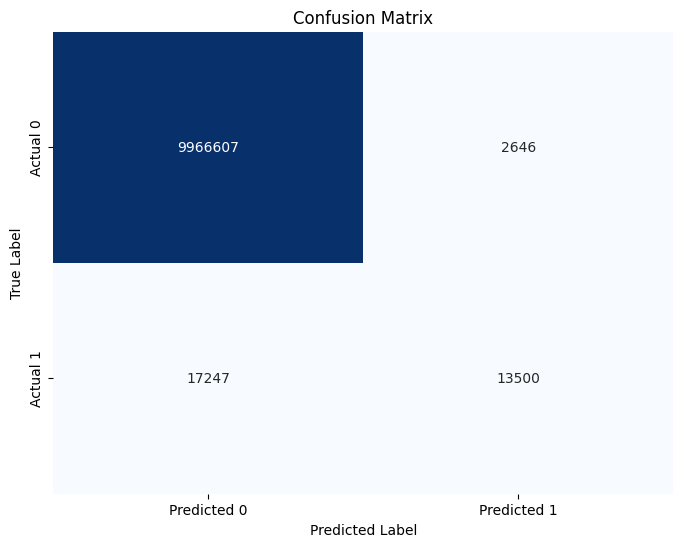

True Negative: 9966607
False Positive: 2646
False Negative: 17247
True Positive: 13500


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix for testing data
conf_matrix = confusion_matrix(yTest, yTest_pred)

# Define labels for confusion matrix
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']

# Reshape confusion matrix to 1D array
conf_matrix = conf_matrix.flatten()

# Create a data frame for confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix.reshape(2, 2), index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Display confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display true positive, true negative, false positive, false negative scores
print("True Negative:", conf_matrix[0])
print("False Positive:", conf_matrix[1])
print("False Negative:", conf_matrix[2])
print("True Positive:", conf_matrix[3])


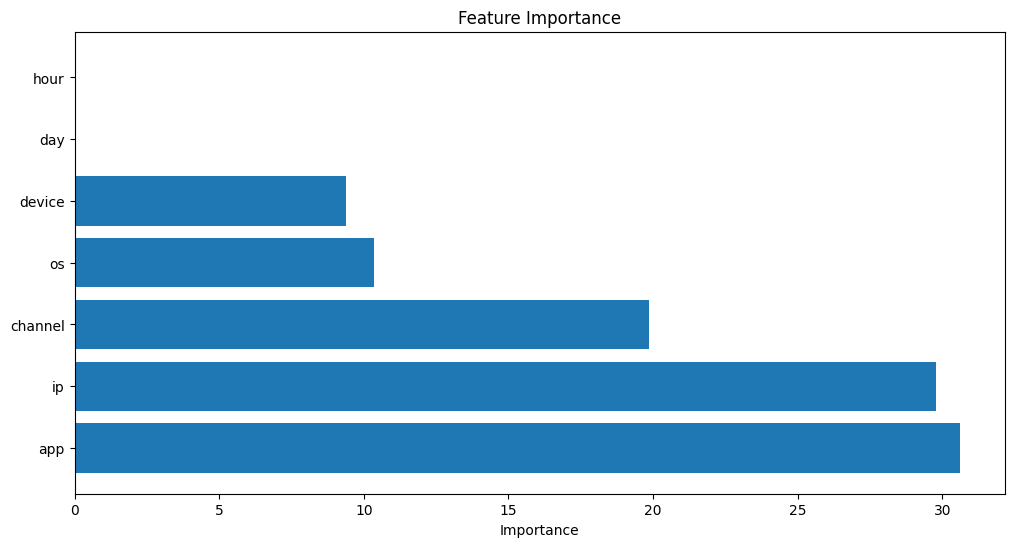

In [ ]:
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
test_pool = Pool(xTest, yTest)

# Get feature importances
feature_importance = best_clf.get_feature_importance(data=test_pool, type='FeatureImportance')

# Get feature names
feature_names = xTest.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [ ]:
feature_importance = best_clf.get_feature_importance(data=test_pool, type='FeatureImportance')

# Get feature names
feature_names = xTest.columns

# Create a dictionary to store feature importances with feature names
importance_dict = {feature_names[i]: feature_importance[i] for i in range(len(feature_names))}

# Sort the dictionary based on feature importances
sorted_importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

# Print out feature importances
for feature, importance in sorted_importance_dict.items():
    print(f"Feature: {feature} - Importance: {importance}")

Feature: ip - Importance: 33.01624249138265
Feature: app - Importance: 23.018992075235534
Feature: channel - Importance: 19.268620104141796
Feature: os - Importance: 17.60881531031587
Feature: device - Importance: 7.087330018924146
Feature: day - Importance: 0.0
Feature: hour - Importance: 0.0
